In [8]:
import os
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt
import torch as th
from model import QComp
from utilities import performance


################################################# SETTING ##################################################
device = th.device("cuda" if th.cuda.is_available() else "cpu")
dtype = th.float32

# load data and model

In [9]:
################################################## LOAD DATA ##################################################
####################################### train data

idx = 0
label_name = "May17_17-09-00"

checkpoint = th.load("saved_data/fold_{}/runs/{}_Macblue.local/model.pth".format(idx, label_name), map_location=device)


dataset_name = "fold_" + str(idx)
dataset_type = "regression"

train_exp_data = pd.read_csv('public_data_results/random_split_data_results/{}/public_admet_data_random_{}_train_set.csv'.format(dataset_name, dataset_name))
train_qsar_data = pd.read_csv('public_data_results/random_split_data_results/{}/chemprop_multitask_pred/public_admet_data_random_{}_train_set_model_pred.csv'.format(dataset_name, dataset_name))
assert np.all(train_exp_data["smiles"] == train_qsar_data["smiles"])


train_exp_data = train_exp_data.drop(columns=["smiles"])
train_qsar_data = train_qsar_data[train_exp_data.columns]

normalization_mean = train_exp_data.mean(axis=0)
normalization_std = train_exp_data.std(axis=0)

#### for better initializing the covariance matrix 
data_std = th.tensor(train_exp_data.std().to_numpy())

#### convert dataframe to pytorch tensor
train_exp_data = th.tensor(train_exp_data.to_numpy()).to(dtype=dtype, device=device)
train_qsar_data = th.tensor(train_qsar_data.to_numpy()).to(dtype=dtype, device=device)



####################################### validation data
val_exp_data_full = pd.read_csv('public_data_results/random_split_data_results/{}/public_admet_data_random_{}_test_set.csv'.format(dataset_name, dataset_name))
val_qsar_data_full = pd.read_csv('public_data_results/random_split_data_results/{}/chemprop_multitask_pred/public_admet_data_random_{}_test_set_model_pred.csv'.format(dataset_name, dataset_name))
assert np.all(val_exp_data_full["smiles"] == val_qsar_data_full["smiles"])

val_exp_data_full = val_exp_data_full.drop(columns=["smiles"])
val_qsar_data_full = val_qsar_data_full[val_exp_data_full.columns]

val_exp_data_full = (val_exp_data_full - normalization_mean) / normalization_std
val_qsar_data_full = (val_qsar_data_full - normalization_mean) / normalization_std

feature_size = train_exp_data.shape[1]
target_index_list = np.arange(feature_size)


In [10]:
# ################################################## LOAD MODEL ##################################################


qcomp = QComp(size=feature_size).to(dtype=dtype, device=device)

qcomp.load_state_dict(checkpoint)

<All keys matched successfully>

# Evaluation

In [11]:
feature_name_list = []
rmse_list, rmse_qsar_list = [], []
pearsonr2_list, pearsonr2_qsar_list = [], []
r2_score_list, r2_score_qsar_list = [], []

for target_index in target_index_list:

    target_feature = val_exp_data_full.columns[target_index]

    print("-----------", target_index, target_feature)

    filter_notna = val_exp_data_full[target_feature].notna()

    val_exp_data = val_exp_data_full[filter_notna]
    val_qsar_data = val_qsar_data_full[filter_notna]

    #### convert dataframe to pytorch tensor
    val_exp_data_th = th.tensor(val_exp_data.to_numpy()).to(dtype=dtype, device=device)
    val_qsar_data_th = th.tensor(val_qsar_data.to_numpy()).to(dtype=dtype, device=device)

    print("Validation set size", val_exp_data_th.shape)
    
    feature_name_list.append(target_feature)

    performance_dict = performance(val_exp_data_th, val_qsar_data_th, target_index, qcomp)
    
    rmse_list.append(performance_dict["rmse_imputation"])
    rmse_qsar_list.append(performance_dict["rmse_qsar"])

    pearsonr2_list.append(performance_dict["pearsonr2_imputation"])
    pearsonr2_qsar_list.append(performance_dict["pearsonr2_qsar"])

    r2_score_list.append(performance_dict["r2_score_imputation"])
    r2_score_qsar_list.append(performance_dict["r2_score_qsar"])


----------- 0 CL_microsome_human
Validation set size torch.Size([1119, 25])
----------- 1 CL_microsome_mouse
Validation set size torch.Size([128, 25])
----------- 2 CL_microsome_rat
Validation set size torch.Size([361, 25])
----------- 3 CL_total_dog
Validation set size torch.Size([64, 25])
----------- 4 CL_total_human
Validation set size torch.Size([160, 25])
----------- 5 CL_total_monkey
Validation set size torch.Size([22, 25])
----------- 6 CL_total_rat
Validation set size torch.Size([82, 25])
----------- 7 CYP2C8_inhibition
Validation set size torch.Size([66, 25])
----------- 8 CYP2C9_inhibition
Validation set size torch.Size([469, 25])
----------- 9 CYP2D6_inhibition
Validation set size torch.Size([481, 25])
----------- 10 CYP3A4_inhibition
Validation set size torch.Size([847, 25])
----------- 11 Dog_fraction_unbound_plasma
Validation set size torch.Size([40, 25])
----------- 12 Human_fraction_unbound_plasma
Validation set size torch.Size([571, 25])
----------- 13 Monkey_fraction_

# plot

In [12]:
mapping_df = pd.read_csv("public_data_results/all_data/data_count_name_unit_info.csv")
mapping_name_list = list(mapping_df["property"])[:-1]
assert mapping_name_list == feature_name_list

feature_short_name_list = mapping_df["short name"][:-1]
feature_short_name_list

0      CL microsome, human
1      CL microsome, mouse
2        CL microsome, rat
3            CL total, dog
4          CL total, human
5         CL total, monkey
6            CL total, rat
7                   CYP2C8
8                   CYP2C9
9                   CYP2D6
10                  CYP3A4
11               Fu,p, dog
12             Fu,p, human
13            Fu,p, monkey
14               Fu,p, rat
15                    Papp
16              PGP, human
17                    hERG
18              LogD pH7.4
19    Kinetic aqueous logS
20     Thermo aqueous logS
21                 Vd, dog
22               Vd, human
23              Vd, monkey
24                 Vd, rat
Name: short name, dtype: object

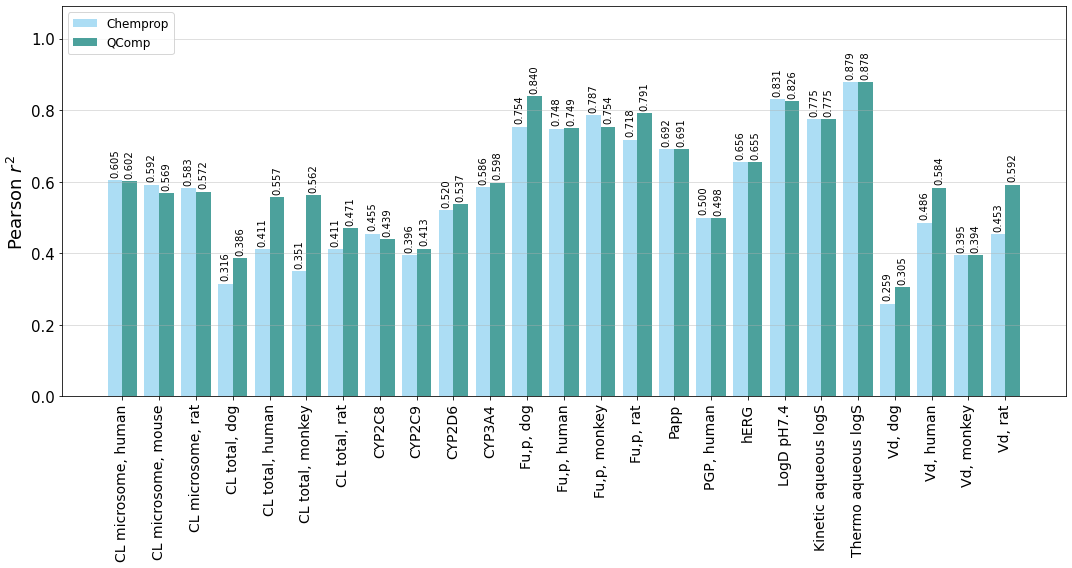

In [13]:
# feature_short_name_list = feature_name_list

bar_width = 0.4

figure, ax = plt.subplots(1, 1, figsize=(15, 8))

x = np.arange(len(feature_short_name_list))
ax.bar(x - bar_width/2, pearsonr2_qsar_list, width=bar_width, alpha=0.7, label="Chemprop", color="#89CFF0")
ax.bar(x + bar_width/2, pearsonr2_list, width=bar_width, alpha=0.7, label="QComp", color="#007a73")
for c in ax.containers:
    ax.bar_label(c, fmt='%.3f', label_type='edge', fontsize=10, rotation=90, padding=3)

ax.set_xticks(x)
ax.set_xticklabels(feature_short_name_list, rotation=90, fontsize=14)

ax.tick_params(axis='y', labelsize=15)
ax.set_ylabel(r"Pearson $r^2$", fontsize=18)

ax.set_ylim(0, 1.09)

# ax.set_title(r"Pearson $r^2$", fontsize=18)
ax.grid(axis="y", alpha=0.5)
ax.legend(fontsize=12, loc="upper left")

plt.tight_layout()

figure.savefig("fig/Pearsonr2_fold_{}.png".format(idx), dpi=300)


In [14]:
# data = {'feature_short_name_list': feature_short_name_list, 
#         'rmse_list': rmse_list, 
#         'rmse_qsar_list': rmse_qsar_list,
#         'pearsonr2_list': pearsonr2_list,
#         'pearsonr2_qsar_list': pearsonr2_qsar_list,
#         'r2_score_list': r2_score_list,
#         'r2_score_qsar_list': r2_score_qsar_list
#         }
# df = pd.DataFrame(data)

# df.to_csv("fig/metrics_fold_{}.csv".format(idx), index=False)